<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [13]:
import re
import string

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy


from bs4 import BeautifulSoup

nlp = spacy.load("en_core_web_lg")

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [14]:
from bs4 import BeautifulSoup as bs
import requests

listings = pd.read_csv('./data/job_listings.csv')
listings.head()

,Unnamed: 0,description,title
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [15]:
# Delete unnamed column

del listings['Unnamed: 0']
listings.head()

,description,title
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [16]:
# Use Beautiful Soup to strip html tags from the 'description' column
listings['description'] = listings['description'].apply(lambda x: bs(x).get_text().replace("\\n", " ").strip("b'").lower())
listings.head()

,description,title
0,"""job requirements: conceptual understanding in...",Data scientist
1,"job description as a data scientist 1, you wi...",Data Scientist I
2,as a data scientist you will be working on con...,Data Scientist - Entry Level
3,"$4,969 - $6,756 a monthcontractunder the gener...",Data Scientist
4,location: usa \xe2\x80\x93 multiple locations ...,Data Scientist


In [51]:
listings['description'][2]

'as a data scientist you will be working on consulting side of our business. you will be responsible for analyzing large, complex datasets and identify meaningful patterns that lead to actionable recommendations. you will be performing thorough testing and validation of models, and support various aspects of the business with data analytics. ability to do statistical modeling, build predictive models and leverage machine learning algorithms. this position will combine the typical data scientist math and analytical skills, with research, advanced business, communication, and presentation skills. primary job location is in sacramento, but work-from-home option is available.  qualifications bachelors, ms or phd in a relevant field (computer science, engineering, statistics, physics, applied math) experience in r and/or python is preferred'

## 2) Use Spacy to tokenize the listings 

In [18]:
# Tokenize listings
listings['tokens'] = listings['description'].apply(nlp)
listings.head()

,description,title,tokens
0,"""job requirements: conceptual understanding in...",Data scientist,"("", job, requirements, :, conceptual, understa..."
1,"job description as a data scientist 1, you wi...",Data Scientist I,"(job, description, , as, a, data, scientist, ..."
2,as a data scientist you will be working on con...,Data Scientist - Entry Level,"(as, a, data, scientist, you, will, be, workin..."
3,"$4,969 - $6,756 a monthcontractunder the gener...",Data Scientist,"($, 4,969, -, $, 6,756, a, monthcontractunder,..."
4,location: usa \xe2\x80\x93 multiple locations ...,Data Scientist,"(location, :, usa, \xe2\x80\x93, multiple, loc..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [19]:
# Using sklearn to get word counts for each listing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 

# Custom Stop Words
added = ['country', ' ']
stop_words = text.ENGLISH_STOP_WORDS.union(added)

# Initializing and fitting CVect
cvect = CountVectorizer(stop_words=stop_words)
dtm = cvect.fit_transform(listings['description'])
# Custom Stop Words
added = ['country', ' ']
stop_words = text.ENGLISH_STOP_WORDS.union(added)

# Initializing and fitting CVect
cvect = CountVectorizer(stop_words=stop_words)
dtm = cvect.fit_transform(listings['description'])


In [20]:
dtm = pd.DataFrame(dtm.todense(), columns=cvect.get_feature_names())
print(dtm.shape)
dtm.head()

(426, 8502)


,00,000,02115,03,0305,0356,04,062,06366,08,...,zero,zeus,zf,zheng,zillow,zogsports,zones,zoom,zuckerberg,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts

In [21]:
counts = Counter()
for row in listings['tokens']:
    for token in row:
        if (token.is_stop != True) and (token.is_punct != True):
            counts[token.orth_] += 1

del counts[' ']

In [22]:
counts.most_common(25)

[('data', 4445),
 ('experience', 1830),
 ('business', 1211),
 ('work', 1153),
 ('team', 967),
 ('science', 957),
 ('learning', 917),
 ('analytics', 728),
 ('machine', 699),
 ('skills', 693),
 ('analysis', 680),
 ('models', 616),
 ('product', 580),
 ('statistical', 576),
 ('new', 529),
 ('solutions', 528),
 ('ability', 513),
 ('scientist', 502),
 ('insights', 462),
 ('help', 458),
 ('technical', 453),
 ('working', 445),
 ('python', 443),
 ('tools', 438),
 ('engineering', 423)]

In [23]:
# Look at most common counts in a data frame

counts_df = pd.DataFrame(counts.most_common(25), columns=['word', 'count'])
counts_df.head(25)


,word,count
0,data,4445
1,experience,1830
2,business,1211
3,work,1153
4,team,967
5,science,957
6,learning,917
7,analytics,728
8,machine,699
9,skills,693


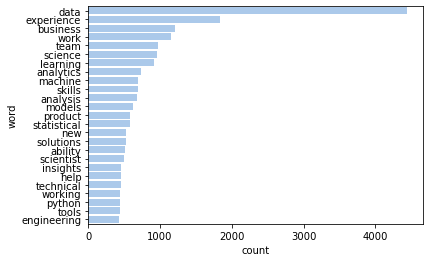

In [35]:
# Using a barchart to explore word counts

sns.set_color_codes("pastel")
sns.barplot(x="count", y="word", data=counts_df,
            label="Total", color="b")

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words=stop_words, max_df=0.95, min_df=0.01, ngram_range=(1,2))
tfidf_dtm = tfidf.fit_transform(listings['description'])

In [38]:
tfidf_dtm = pd.DataFrame(tfidf_dtm.todense(), columns=tfidf.get_feature_names())
print(tfidf_dtm.shape)
tfidf_dtm.head()

(426, 6138)


,000,000 employees,10,10 years,100,100 000,100 companies,100 countries,11,12,...,years industry,years professional,years related,years relevant,years work,years working,years xe2,yes,york,york city
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [40]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=5, algorithm="kd_tree")
nn.fit(tfidf_dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [52]:
nn.kneighbors([tfidf_dtm.iloc[2]])

(array([[0.        , 1.29645675, 1.29821474, 1.30635495, 1.31175754]]),
 array([[  2, 307, 190, 318, 338]], dtype=int64))

In [53]:
listings['description'].iloc[2][:300]

'as a data scientist you will be working on consulting side of our business. you will be responsible for analyzing large, complex datasets and identify meaningful patterns that lead to actionable recommendations. you will be performing thorough testing and validation of models, and support various as'

In [55]:
listings['description'].iloc[307][:300]

'job description  toomey technologies has immediate openings for talented and motivated data scientists in northern virginia. our solutions require integrated models based on large and varied datasets, feeding analytic applications so that we can extract patterns and behaviors obscured within the dat'

In [58]:
my_resume = ['''/
DATA SCIENTIST
KRISTA SHEPARD
Summary
Challenger of conventional wisdom that will always ask why. Over 5 years experience improving customer experience
and sales through smart, strategic thinking that anticipates outcomes. Present visuals and cases that influence and
lead change and drives efficiency and profitability.
Employment
Consultants for Children Lakewood CO
Treatment Plan Manager
- Obtained information and documentation from case management to communicate with funding sources and the
billing department to ensure each service plan was renewed seamlessly.
- Developed processes to include organizational, time management, and filing systems to meet the needs of this new
role and any employees hired for my team.
- Ensured accurate and timely data entry and document uploads to ensure HIPAA compliance and record keeping.
- Advance use of numerous software suites including Microsoft Office, Adobe, and various insurance portals.
Denver Public Schools Denver CO
Math Intervention Teacher
- Student growth average of 1 grade level, with top students showing 2 grade levels of growth in a 3 month period.
- Extensive experience with data tracking and analysis by maintaining and using trackers for daily exit ticket data,
family contact rates, test scores, classroom work, individual/specific student action plans, student problem solving
growth, and maximizing instructional time during class.
- Developed complex lesson plans that include tiered questions, multiple ways to differentiate lesson explanations,
and preparations to address the common misconceptions and anticipated challenges.
- Worked with students from a wide range of circumstances including a visually impaired student, students with
individual behavior plans (IEPs), students with reading and other learning disabilities, English language learners, and
students previously in alternative education programs such as PACE.
- Built relationships with students, family members, and the school community to become a mentor they trust - one of
the most important factors in determining the success of individual students and the program as a whole.
MG Stone LLC Denver CO
Office Manager
- Built a customer information database which positively affected the company’s customer service and revenue
through technological advancement.
- Increased office organization by developing more efficient filing system and customer database protocols.
- As a team member, contributed to 32% increase in sales by gaining new corporate accounts and arranging credit
lines for customers through local banking institutions.
- Maintained 100% compliance by filing the appropriate documentation with e government entities in a timely manner.
- Supervised sales and labor force and provided guidance and training as needed to expand employee skill set.
Contact
kjshepard70@hotmail.com
kristashepard.com
720-879-4950
https://www.linkedin.com/in/kshepard/
kryssyco



 510 S. Dahlia Cir Apt B105
Glendale, CO 80246


Education
Lambda School June 2019 to Current
Data Science 2020
University of Denver
Graduate School of Social
Work
June 2007 to
Aug. 2008
MSW Child Protection 2008
Metropolitan State
College of Denver
May 2005 to
June 2007
BSW Social Work - General 2007
Skills
TOOLS AND TECHNOLOGY
Microsoft Office
Python
SQLite3
PostgreSQL
MongoDB
GitHub
Data Entry
Data Visualization
SQL
JSON
Algorithms
Data Structures
OOP
MySQL
Docker
Git
NoSQL
Data Prep
INDUSTRY KNOWLEDGE
Statistical Data Analysis
Statistical Modeling
Data Analysis
Non Profits
Project Management
Case Management
Mental Health Care
Trauma Recovery
Machine Learning
Unit Testing
Data Mining
Big Data
ETL''']

In [60]:
new_matrix = tfidf.transform(my_resume)
nn.kneighbors(new_matrix.todense())

(array([[1.26870086, 1.29282723, 1.29292541, 1.30199787, 1.30377059]]),
 array([[129,  30, 196, 201, 183]], dtype=int64))

In [64]:
listings['description'].iloc[129][:2500]

'about trilogy: powered by big dreams and small egos, trilogy is reimagining how skills-based learning can change the face of education. we work with experienced instructors, innovative employers, and top universities to create boot camps that prepare highly-motivated students for high-growth careers. and although we\\\'ve successfully graduated hundreds of students, this is truly day 1 for us.  driven by a one-team mentality, we\\\'re looking for those with the hunger, talent, and passion to ride this wave with us.  trilogy is the first of its kind to bring the successful web development boot camp model in house to academic institutions while supporting the entire student academic journey. our platform combines coding curriculum, student recruitment, and career placement services to elevate graduates for increased job market success. we are in high-growth mode and rapidly expanding our family of partners.  our values: 1. we put students first  we put students first because they deserv

In [66]:
listings['description'].iloc[30][:2500]

"internshipoverview every day at perspecta, we enable hundreds of thousands of people to take on our nation\\xe2\\x80\\x99s most important work. we\\xe2\\x80\\x99re a company founded on a diverse set of capabilities and skills, bound together by a single promise: we never stop solving our nation\\xe2\\x80\\x99s most complex challenges. our team of engineers, analysts, developers, investigators, integrators and architects work tirelessly to create innovative solutions. we continually push ourselves\\xe2\\x80\\x94to respond, to adapt, to go further. to look ahead to the changing landscape and develop new and innovative ways to serve our customers.  perspecta works with u.s. government customers in defense, intelligence, civilian, health care, and state and local markets. our high-caliber employees are rewarded in many ways\\xe2\\x80\\x94not only through competitive salaries and benefits packages, but the opportunity to create a meaningful impact in jobs and on projects that matter. persp

In [67]:
listings['description'].iloc[196][:2500]

"temporary, internshipoverview getting real world experience prior to graduation is invaluable in determining career goals and aspirations. students with actual work experience have an advantage, as they begin their job search. as an intern at canon u.s.a., you will be exposed to business, marketing and strategy initiatives. you will be involved in projects that help you learn, develop business skills, and provide a meaningful contribution to canon\\'s business and goals. the canon insights program will give you access to various departments within canon, as well as our key leaders.  - the canon insights internship program is a summer program that will run from june 3, 2019 - august 9, 2019. it is a full time (9am-5pm) schedule, based on a 35 hour work week, and is a paid internship. responsibilities this program is designed to provide undergraduate students with an opportunity to gain hands-on work experience by participating in significant work projects, training, meetings, presentat

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 